I'll use the standard Hopfield network model with deterministic update rule to store MNIST digits (I'll store one image from each digit class). I look at dynamics of the network initialized with both (1) stored patterns, and (2) noisy versions of stored patterns.

## Imports...

In [4]:
# enables plotting inline of Jupyter notebooks
%matplotlib inline

# autoreloading of modules
%load_ext autoreload
%autoreload 2

import numpy as np
import math

from network import HopfieldNetwork
from pattern_tools import PatternFactory
import pattern_tools, plot_tools, util

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Storing MNIST Digit Patterns

We find and store one of each of the MNIST digits, which we will use to classify all other digits.

In [71]:
# load the MNIST data
images, labels = util.load_mnist()

Preprocessing data by thresholding values greater than a constant $c$ to 1 and values less than or equal to $c$ to -1.

In [72]:
# change this to change thresholding preprocessing behavior
c = 1

# bipolarizing the MNIST digits
images = np.asarray(2 * (images >= c) - 1, dtype=np.int)

Now, we look for a single digit example from each digit class (0 through 9).

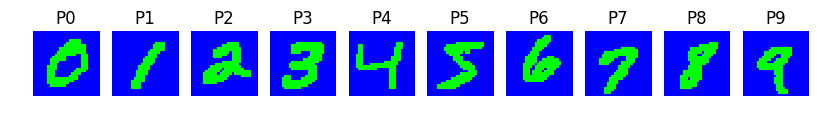

In [77]:
# get one of each of the MNIST digits by label (0 through 9)
images_to_store = []
# look for a digit example by i = 0, ..., 9
for i in range(10):
    for idx, img in enumerate(images):
        # if the label matches the current digit we're looking for
        if labels[idx] == i:
            # store the corresponding image
            images_to_store.append(img)
            break
            
# plot the selected MNIST digit patterns (thresholded and bipolarized)
plot_tools.plot_pattern_list(images_to_store)

Now, we create the fully-connected Hopfield network, store the images we chose from the MNIST data, and visualize the matrix of network weights.

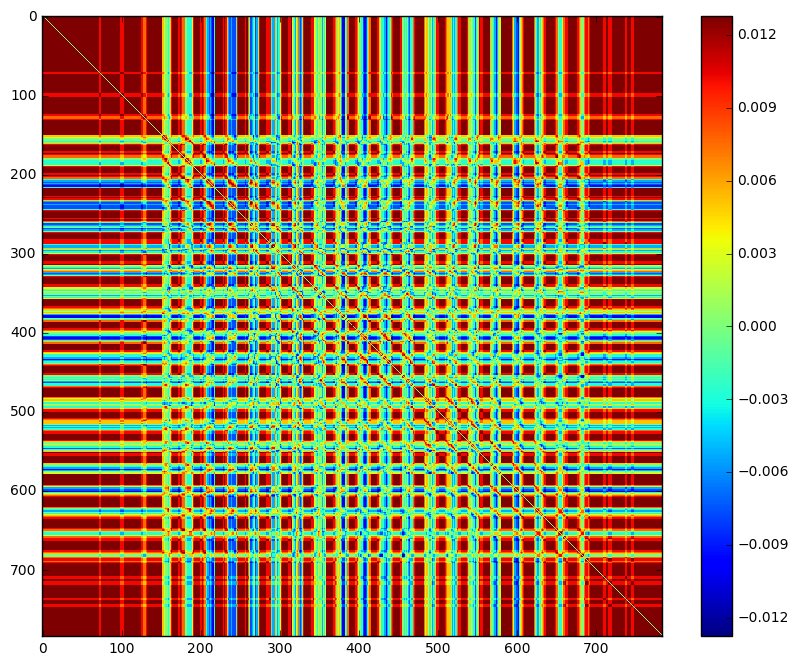

In [78]:
# create fully connected Hopfield network with 28 x 28 neurons
nn = HopfieldNetwork(nr_neurons=28*28, connectivity='full')

# store the patterns in the network
nn.store_patterns(images_to_store)

# take a look at network weights
plot_tools.plot_network_weights(hopfield_network=nn)

## Evaluating the Model

Let's try initializing the network with each of the stored patterns in turn, and see whether or not they are fixed points of the dynamics.

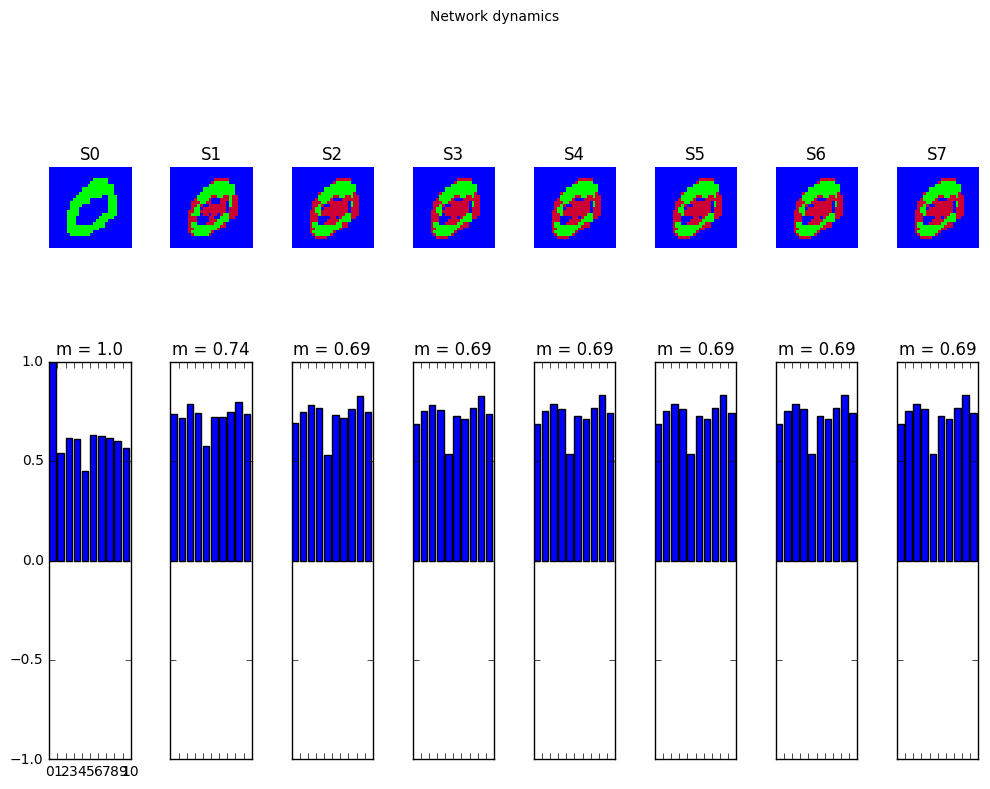

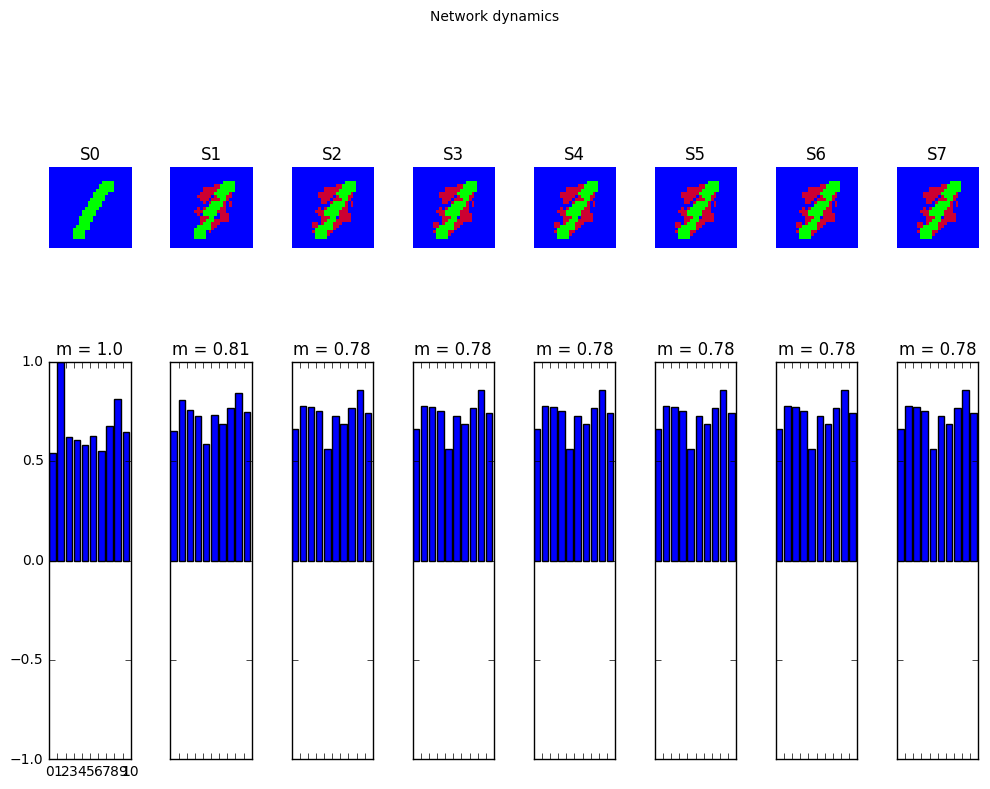

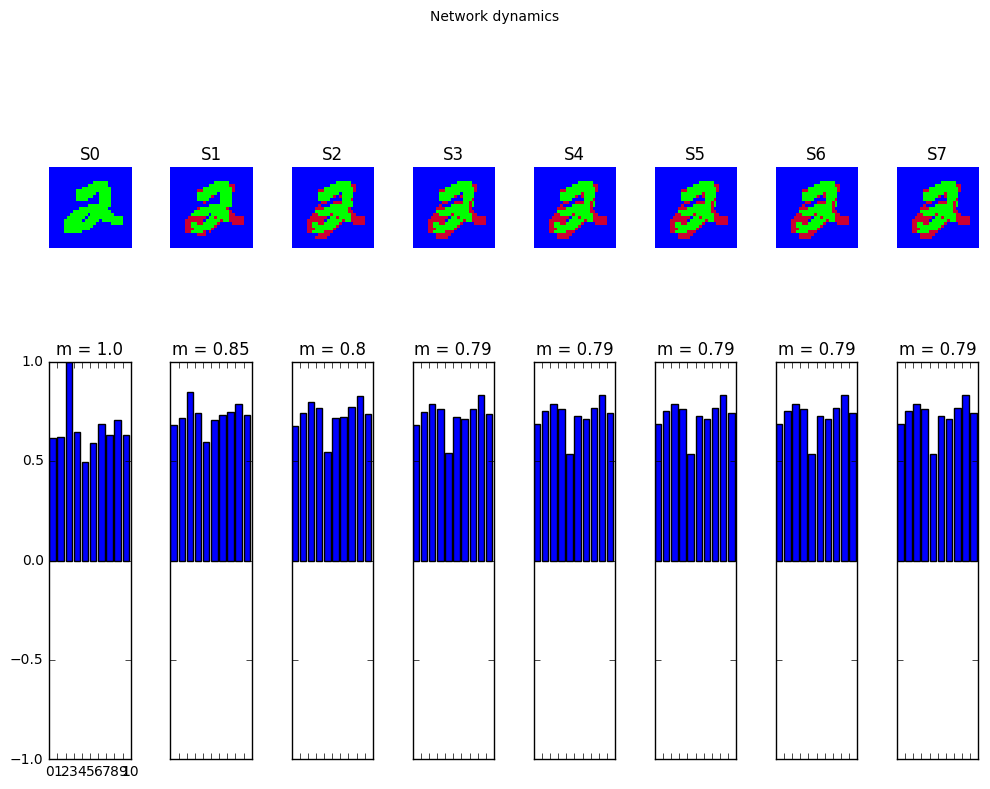

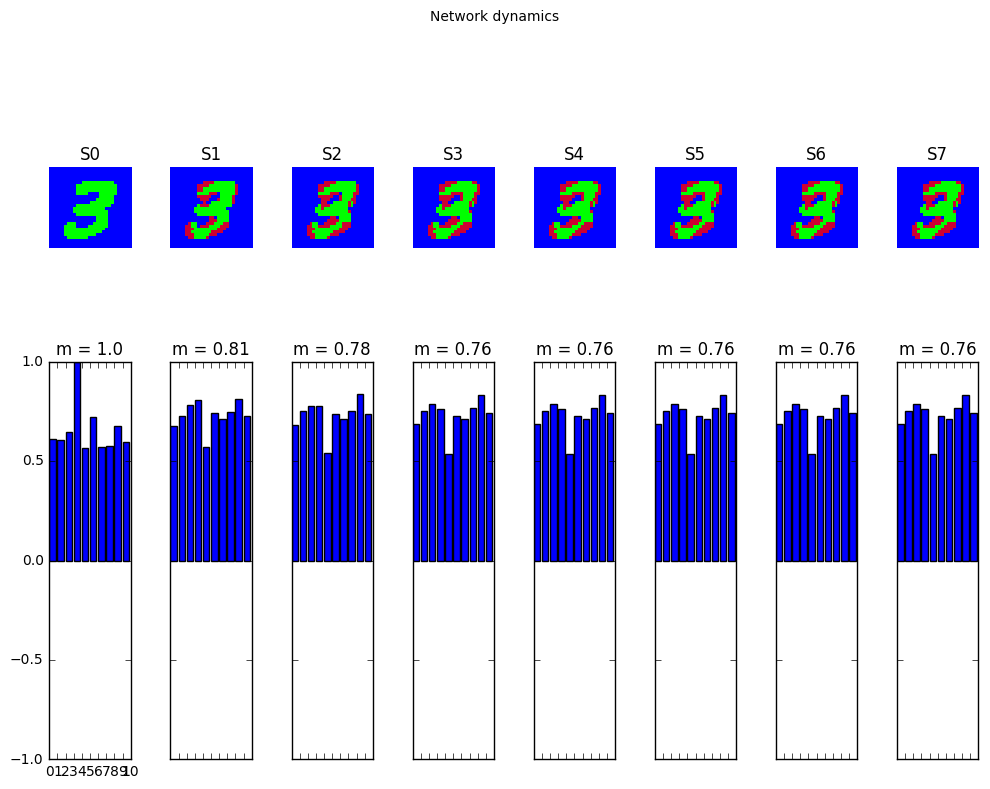

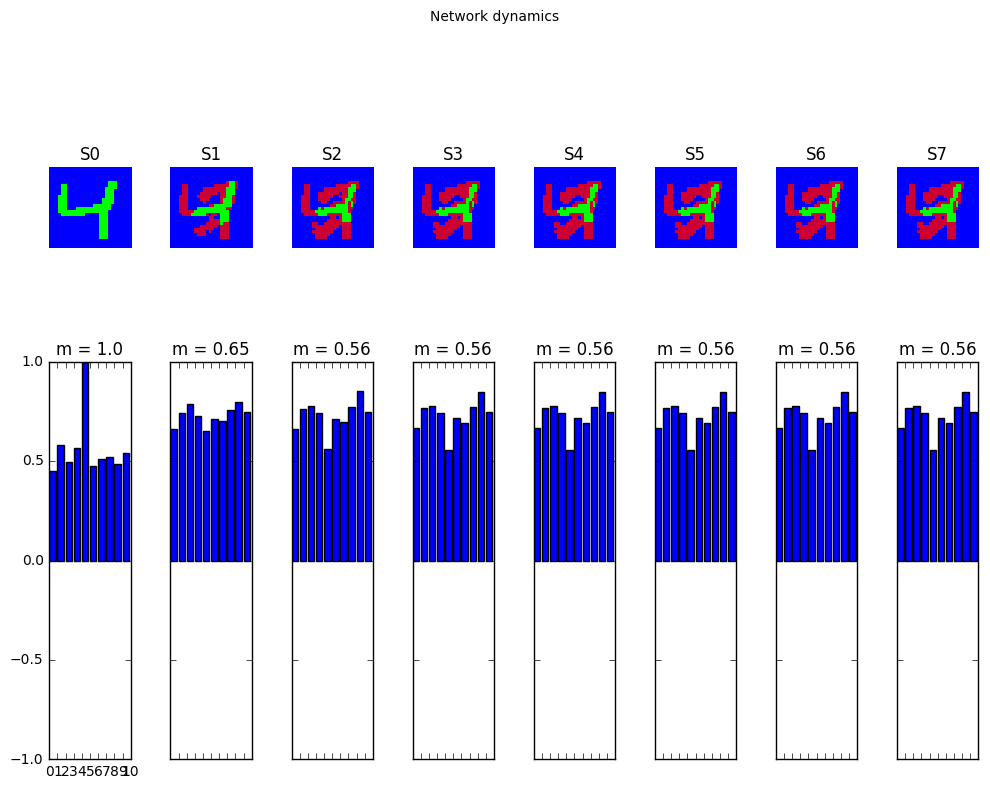

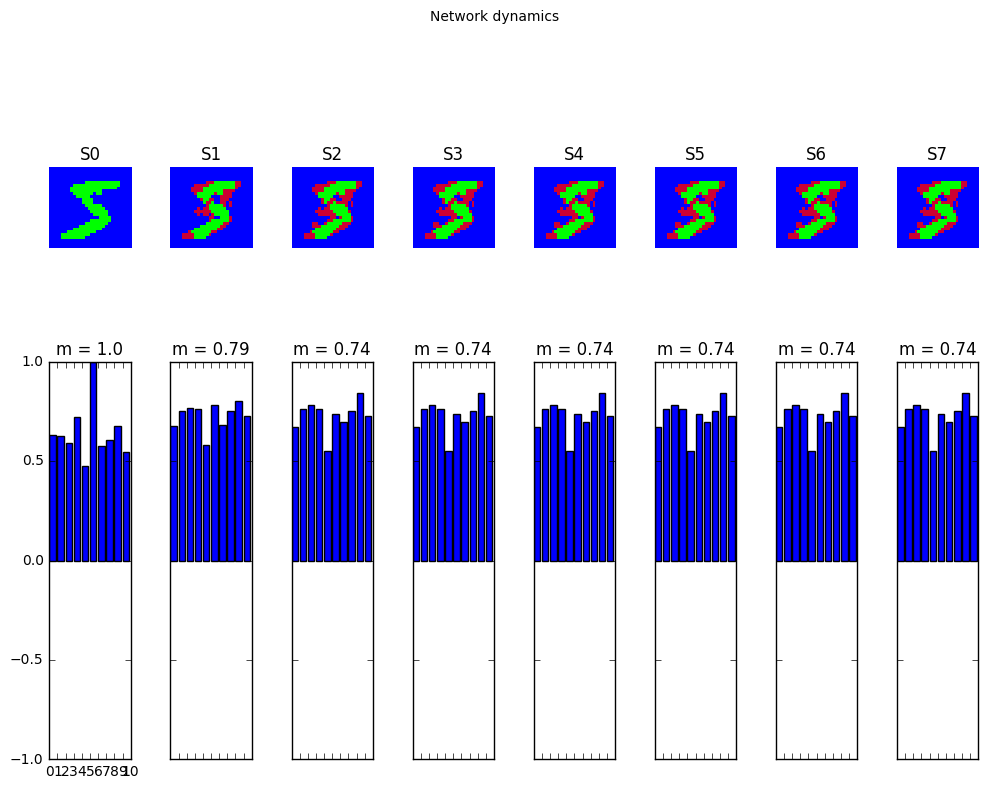

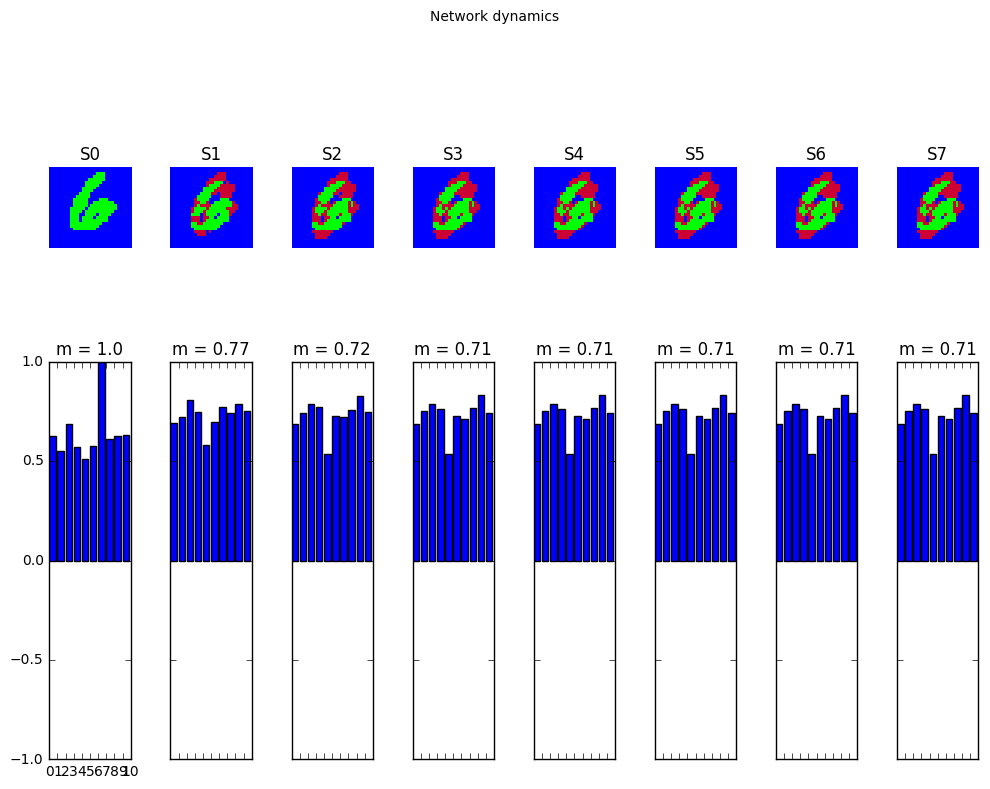

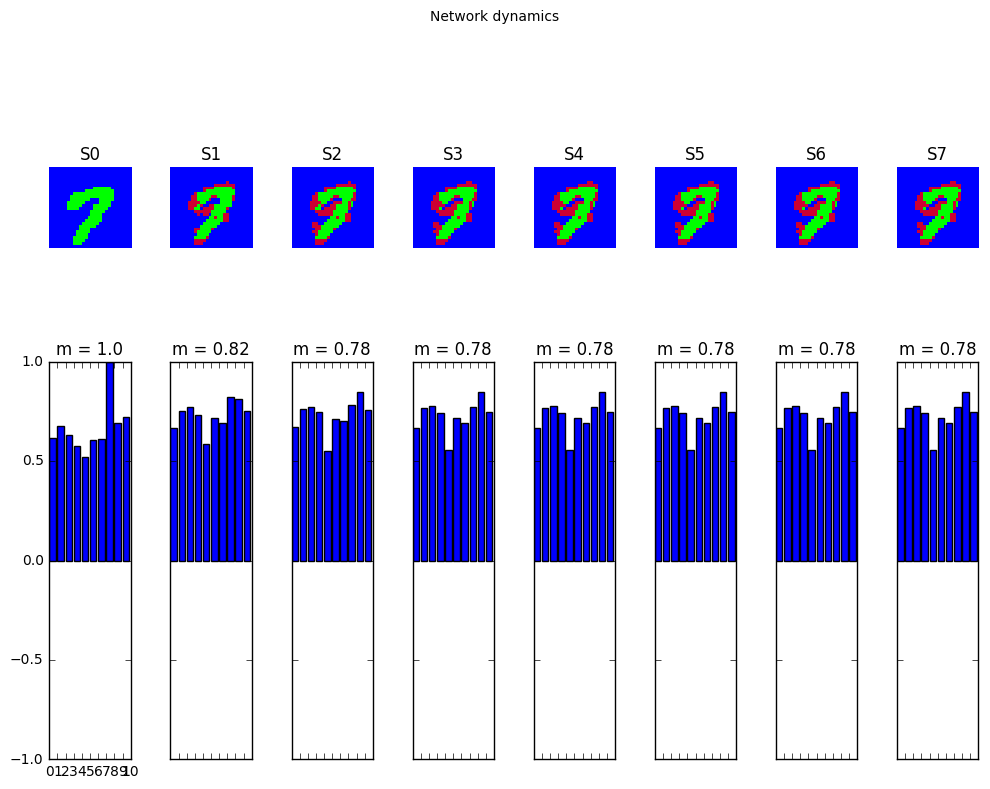

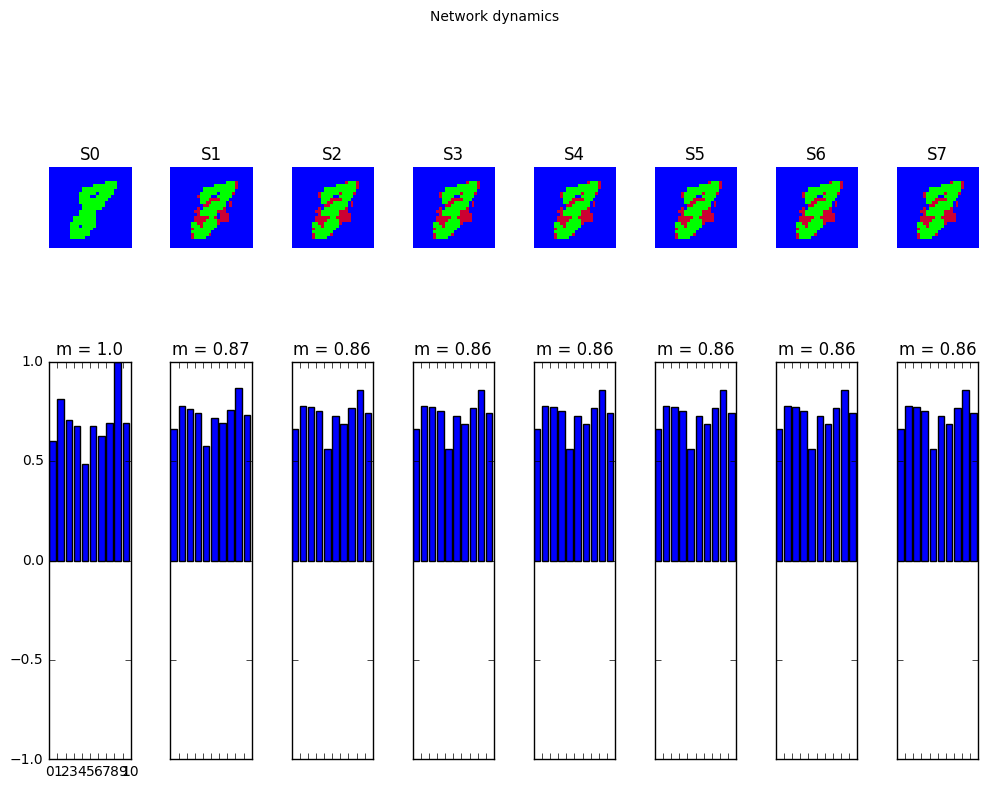

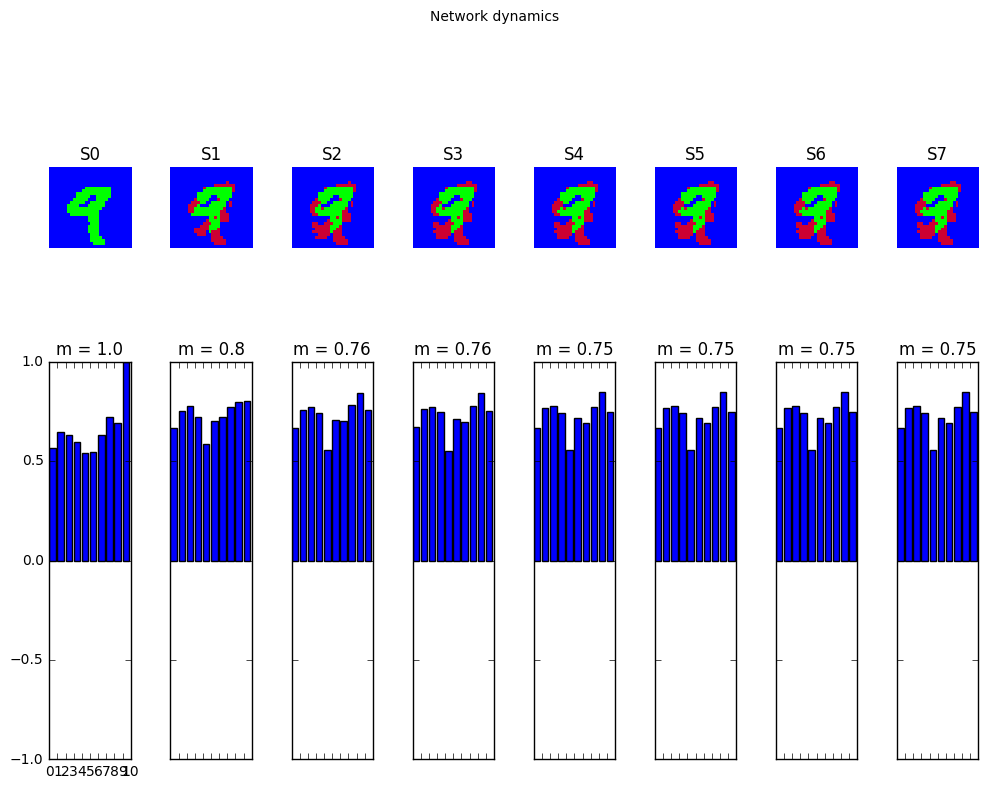

In [75]:
# create pattern factory for pattern reshaping
factory = pattern_tools.PatternFactory(pattern_length=28, pattern_width=28)

# number of steps to unroll the network's dynamics
nr_steps = 7

# try to recall all 10 chosen digit patterns from noisy versions of themselves
for idx, stored_image in enumerate(images_to_store):
    # set the initial state of the Hopfield network as the stored image
    nn.set_state_from_pattern(stored_image)
    
    # let the dynamics evolve from this initial state
    states = nn.run_with_monitoring(nr_steps=nr_steps)
    
    # each network state is a vector. reshape it to the same shape used to create the patterns.
    states_as_patterns = factory.reshape_patterns(states)
    # plot the states of the network
    plot_tools.plot_state_sequence_and_overlap(states_as_patterns, images_to_store, reference_idx=idx, suptitle="Network dynamics")

Now, let's try to recall each of the patterns in turn, by flipping 10% of the states of the stored patterns randomly and letting the network dynamics evolve.

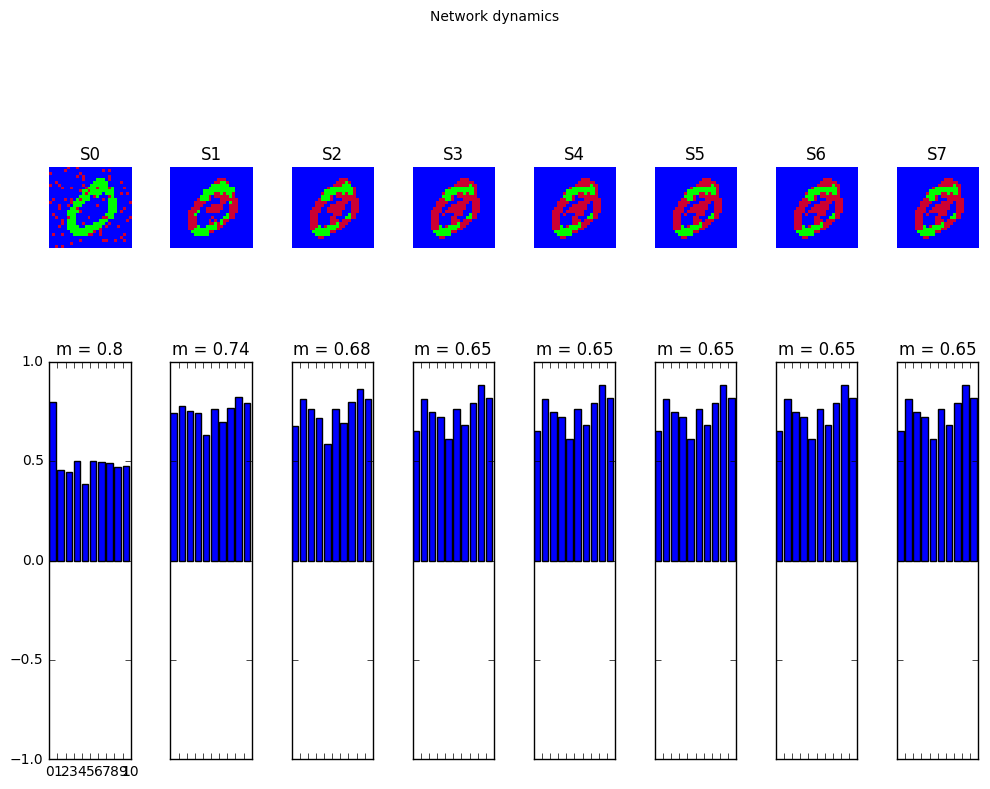

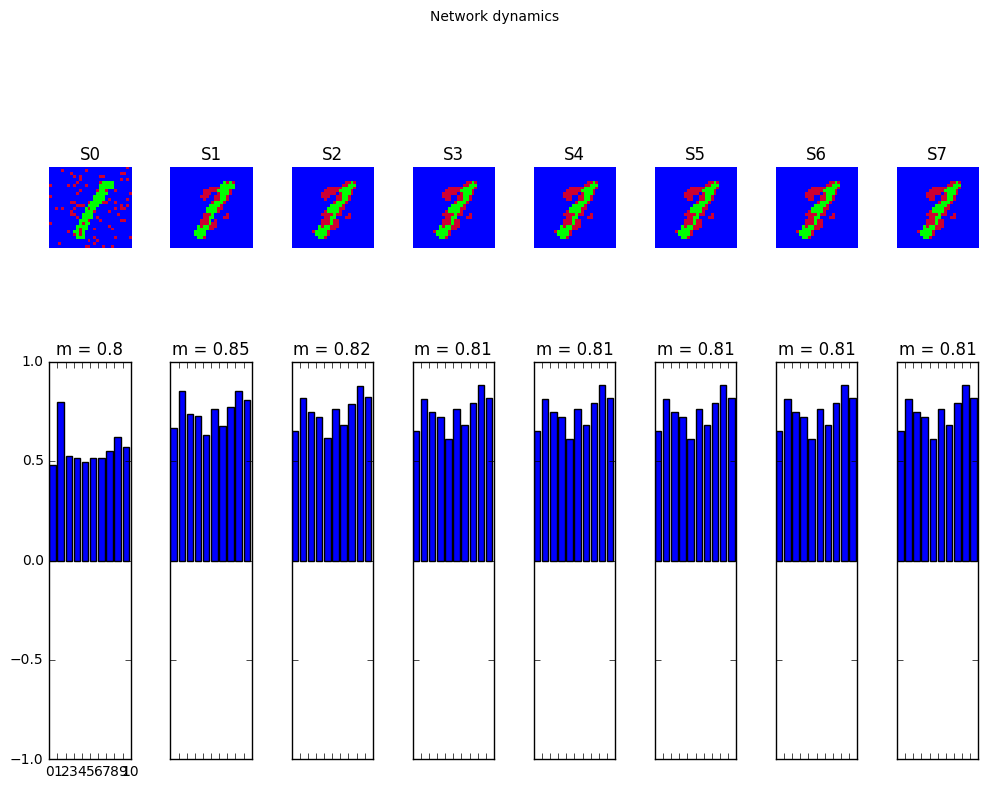

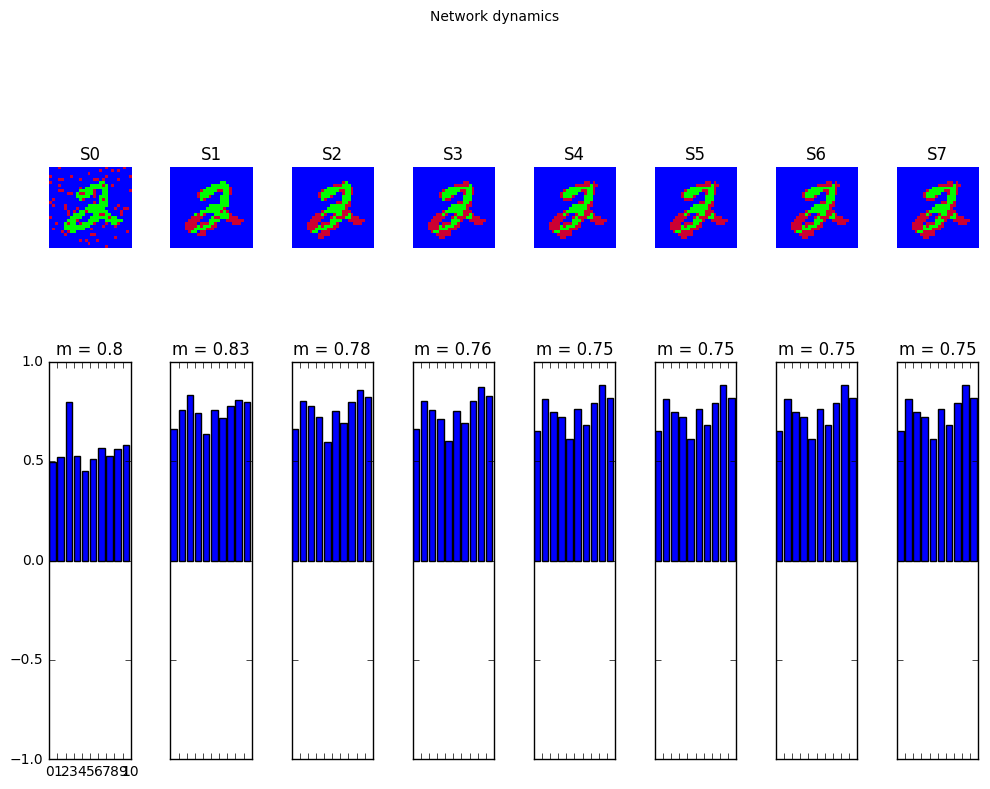

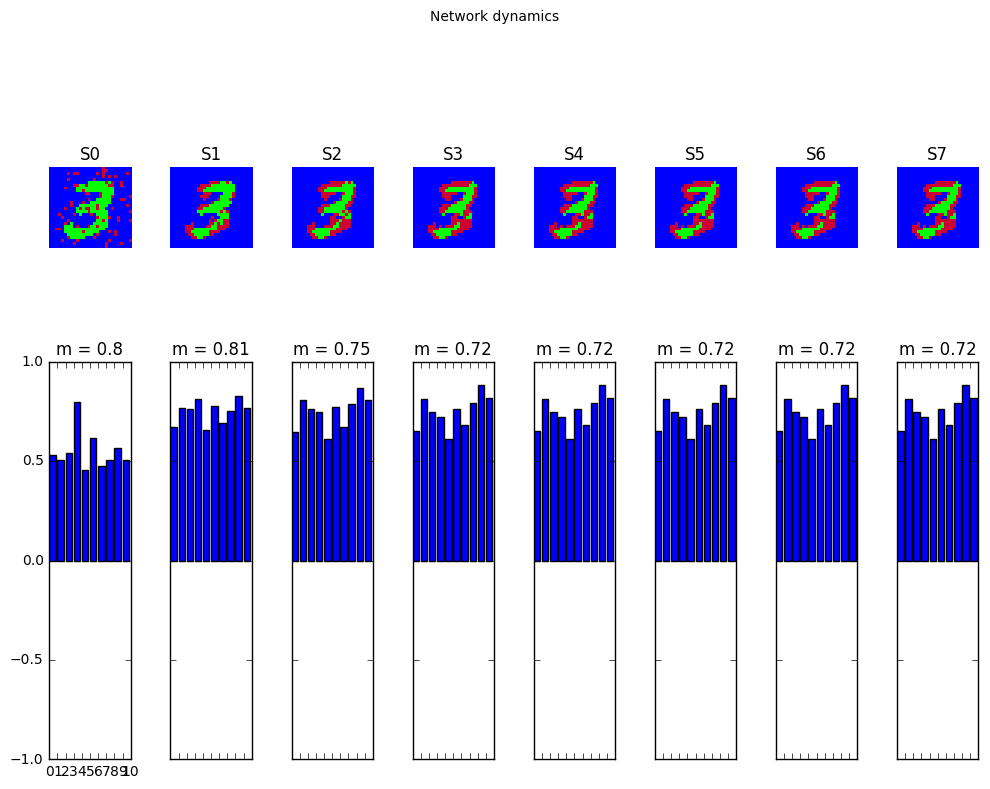

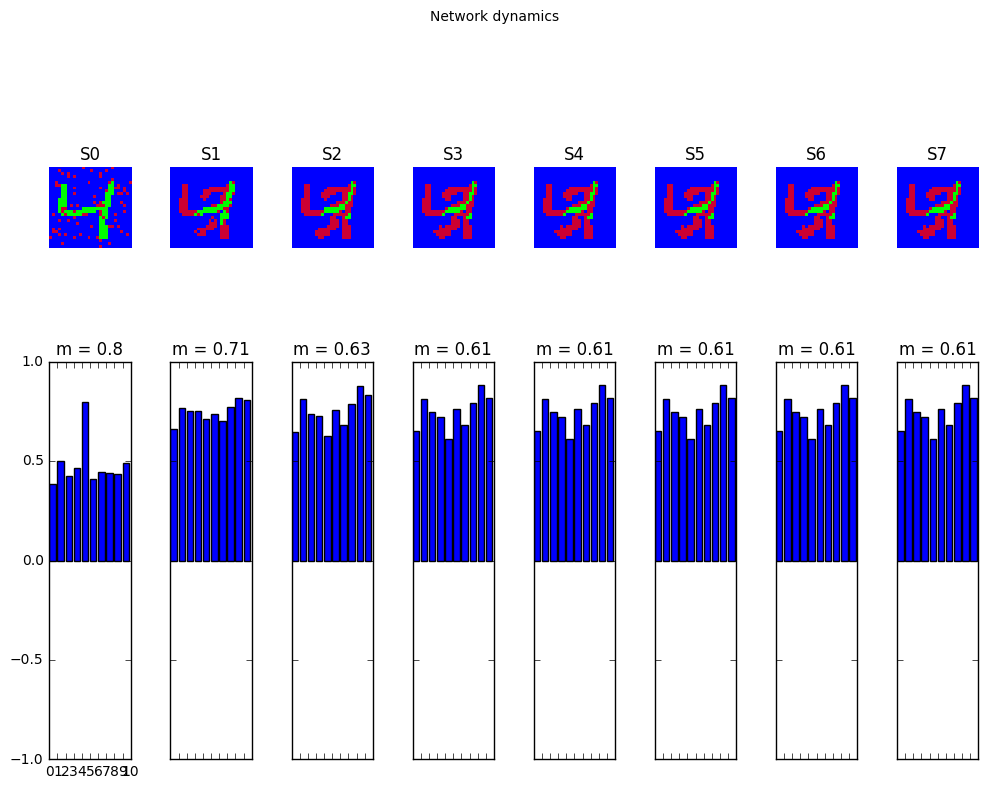

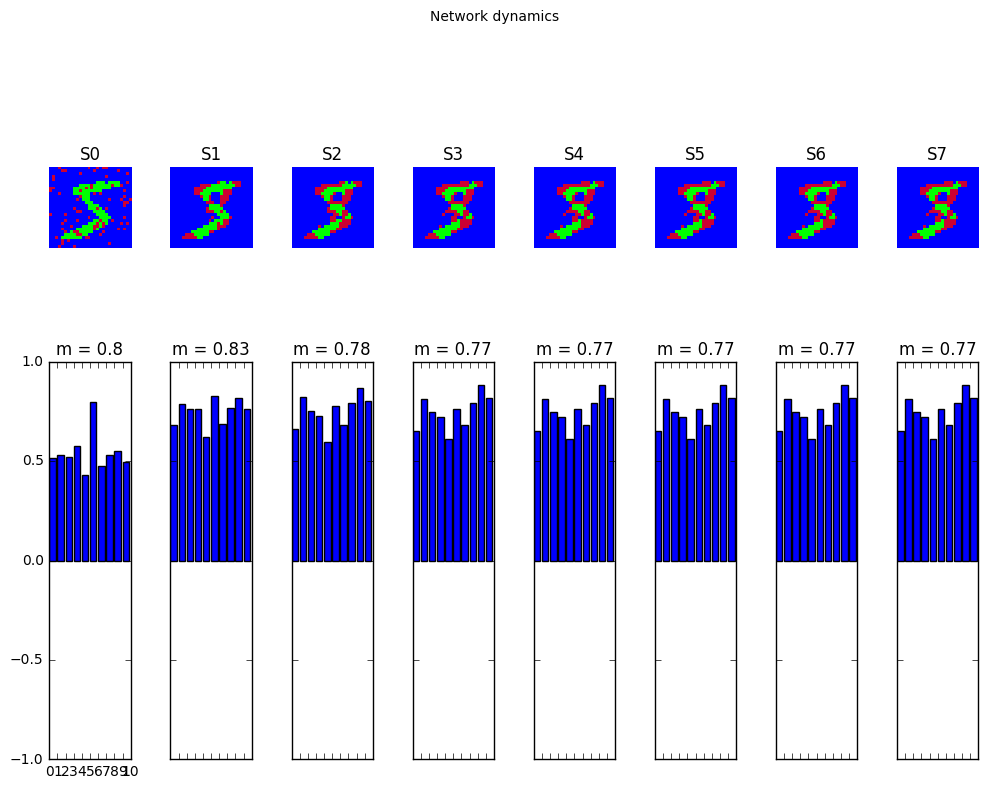

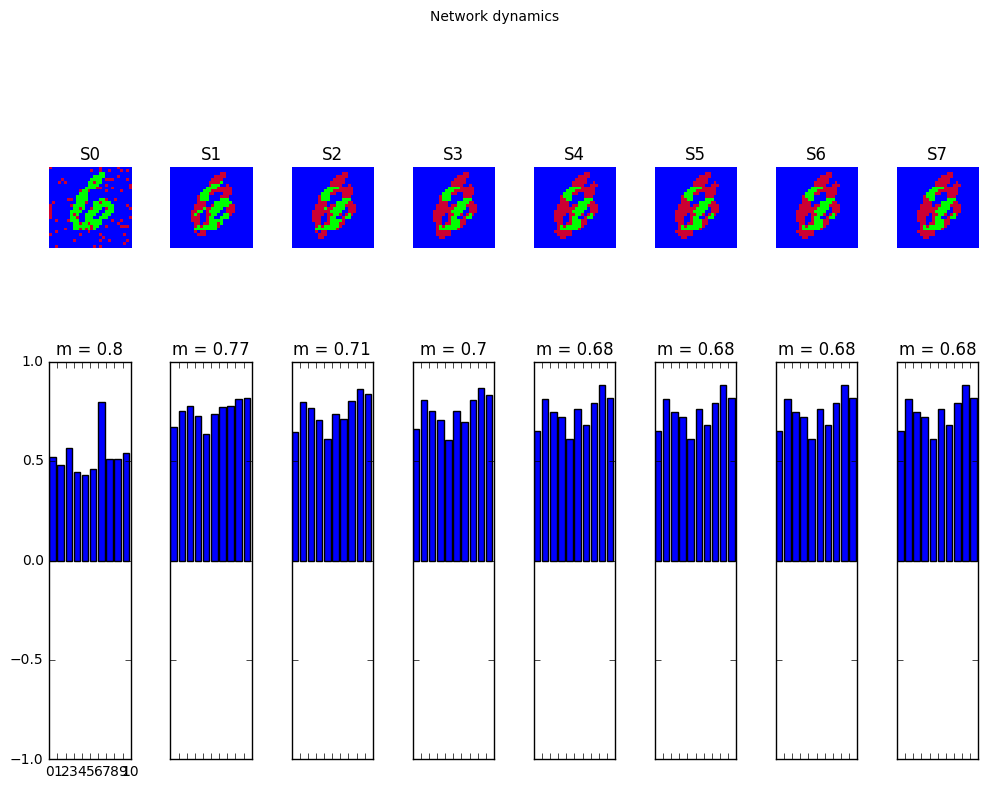

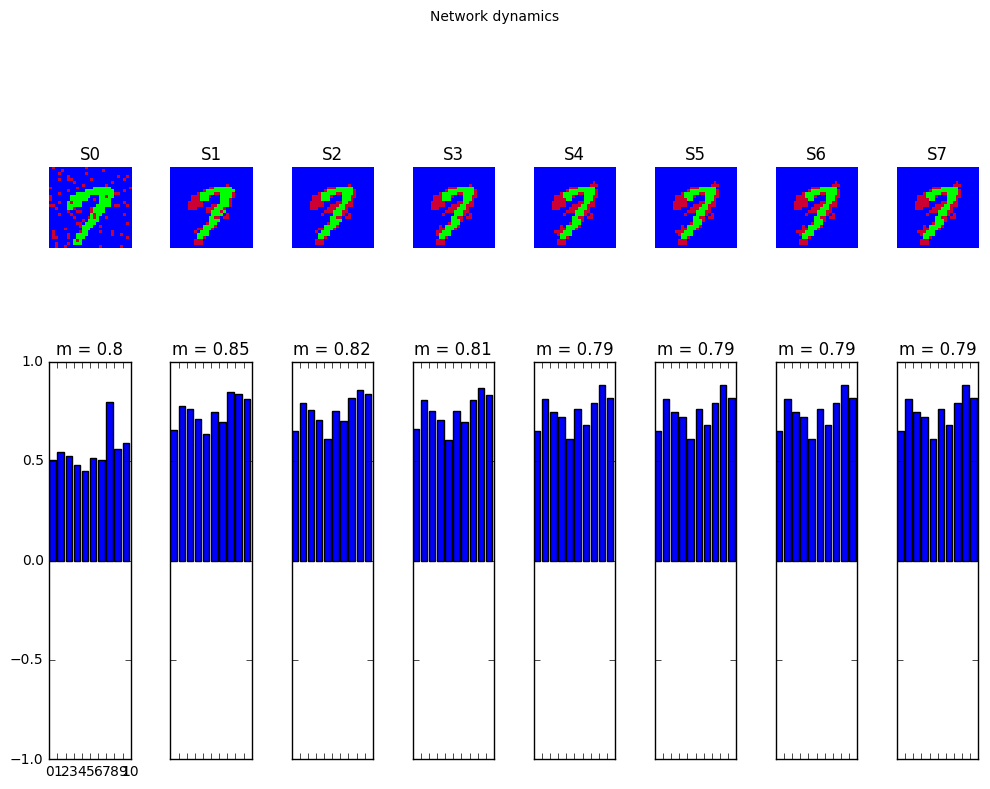

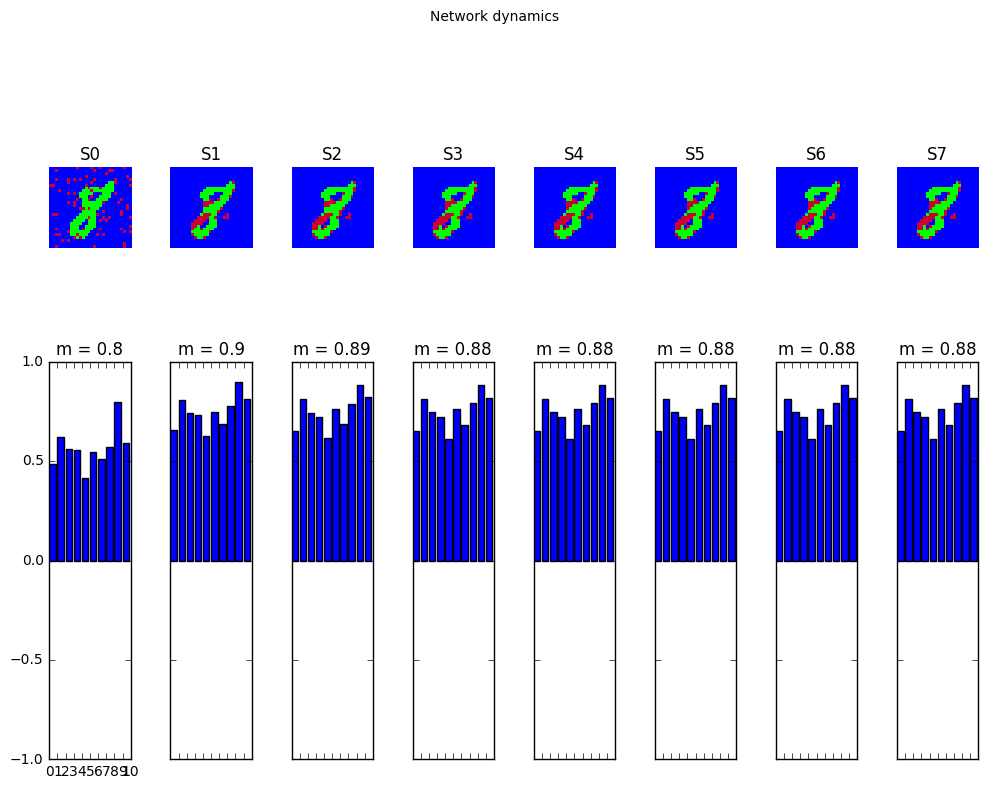

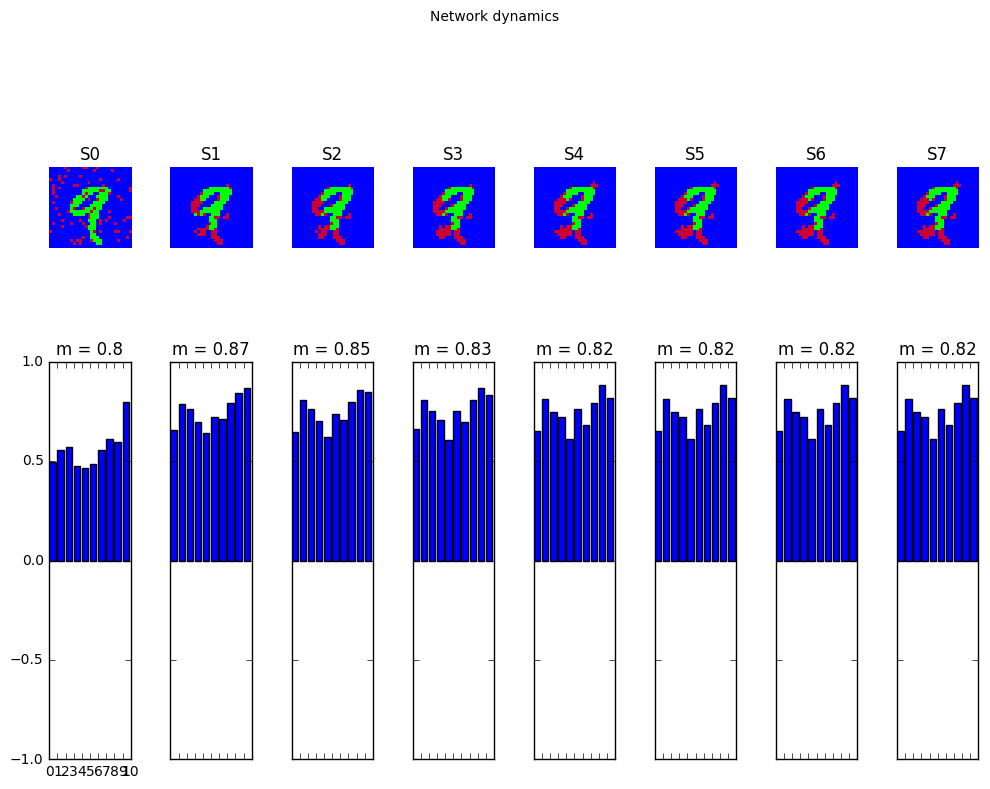

In [50]:
nr_of_flips = int(math.ceil(0.1 * 784)) # 10% of the number of neurons in the network

# try to recall all 10 chosen digit patterns from noisy versions of themselves
for idx, stored_image in enumerate(images_to_store):
    # get a noisy copy of the pattern
    noisy_init = pattern_tools.flip_n(stored_image, nr_of_flips=nr_of_flips)
    # set the initial state of the Hopfield network as the noisy copy
    nn.set_state_from_pattern(noisy_init)
    
    # let the dynamics evolve from this initial state
    states = nn.run_with_monitoring(nr_steps=nr_steps)
    
    # each network state is a vector. reshape it to the same shape used to create the patterns.
    states_as_patterns = factory.reshape_patterns(states)
    # plot the states of the network
    plot_tools.plot_state_sequence_and_overlap(states_as_patterns, images_to_store, reference_idx=idx, suptitle="Network dynamics")

## Conclusion

The fully connected model cannot even store and recall 10 MNIST digit examples. With 10 / 784 being approximately equal to 0.013, this fraction is well below the calculated theoretical limit of 0.138, which corresponds to approximately 108 patterns.

This is likely due to the high correlation between the input patterns, as opposed to the random nature of the patterns typically stored in Hopfield networks. Namely, many of the "on" pixels of the handwritten digit patterns are shared across most images, by virtual of being near the center of the image. On the other hand, in possibly all images, all border pixels are set to "off". For this reason, on initialization of the network with a stored pattern, we observe high overlap with all other stored patterns.